# Description

In this notebook, I will explorethe `processed_data`.

The purpose of this notebook is:
- Inspect any **Unusual** word in the training/testing dataset. 
- Determine hyper-parameter for the Transformer model.

In [3]:
import os
import sys
sys.path.append('../')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try: tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:   print(e)

import multiprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
import string
import nltk

from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset
import tensorflow_text as tf_text

from utils.read_file_utils import *
from utils.tokenizer_utils import *

2024-11-07 17:45:50.879733: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-07 17:45:50.879751: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-07 17:45:50.879765: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/home/necphy/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [4]:
PATH_EN_FILE_TRAIN = r"../data/processed_data/en_sent_train.txt"
PATH_VI_FILE_TRAIN = r"../data/processed_data/vi_sent_train.txt"

PATH_EN_FILE_TEST = r"../data/processed_data/en_sent_test.txt"
PATH_VI_FILE_TEST = r"../data/processed_data/vi_sent_test.txt"

PATH_FOLDER_VOCAB = r"../data/vocab"

FILE_NAME_BPE_TOKENIZER = "vi_bpe_tokenizer.txt"
FILE_NAME_SPACE_TOKENIZER = "vi_space_tokenizer.txt"

# 1. Read dataset

In [5]:
list_en_sentence_train = read_text_file(PATH_EN_FILE_TRAIN)
list_vi_sentence_train = read_text_file(PATH_VI_FILE_TRAIN)

assert len(list_en_sentence_train) == len(list_vi_sentence_train)
print(f"Number of pair sentence: {len(list_en_sentence_train)}")

Number of pair sentence: 2408732


In [26]:
idx = np.random.randint(0, len(list_en_sentence_train))
en = list_en_sentence_train[idx]
vi = list_vi_sentence_train[idx]
print("En:   ", en)
print("Vi:   ", vi)

En:    users can have objects printed in over 55 materials and finishes , these include: plastics , precious metals , steel and food - safe ceramics , which were discontinued and have been replaced by porcelain materials .
Vi:    người dùng có thể có các đối tượng được in trên 55 loại vật liệu và hoàn thiện , bao gồm: nhựa , kim loại quý , thép và gốm sứ an toàn thực phẩm , đã bị ngừng và được thay thế bằng vật liệu sứ .


# 2. Explore dataset

## 2.1. Sequence length and Padding

In [ ]:
list_en_sentence_length = [len(en.split()) for en in list_en_sentence_train]
list_vi_sentence_length = [len(vi.split()) for vi in list_vi_sentence_train]

print(f"Max length of English sentence: {max(list_en_sentence_length)}")
print(f"Min length of English sentence: {min(list_en_sentence_length)}")
print(f"Average length of English sentence: {np.mean(list_en_sentence_length)}")
print(f"Median length of English sentence: {np.median(list_en_sentence_length)}")
print()
print(f"Max length of Vietnamese sentence: {max(list_vi_sentence_length)}")
print(f"Min length of Vietnamese sentence: {min(list_vi_sentence_length)}")
print(f"Average length of Vietnamese sentence: {np.mean(list_vi_sentence_length)}")
print(f"Median length of Vietnamese sentence: {np.median(list_vi_sentence_length)}")

Max length of English sentence: 219
Min length of English sentence: 1
Average length of English sentence: 15.004067285194036
Median length of English sentence: 11.0

Max length of Vietnamese sentence: 182
Min length of Vietnamese sentence: 1
Average length of Vietnamese sentence: 18.397091913919855
Median length of Vietnamese sentence: 14.0


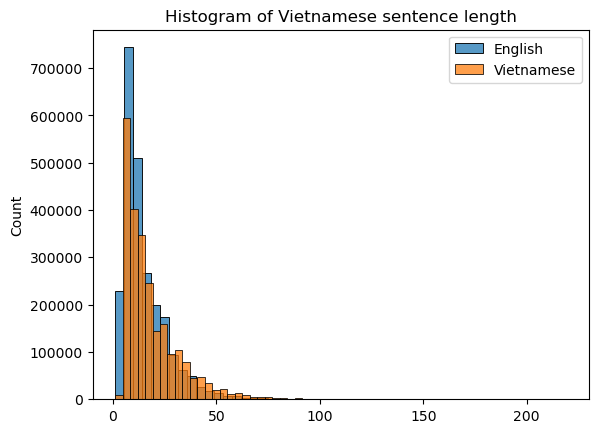

In [20]:
sns.histplot(list_en_sentence_length, bins=50)
plt.title("Histogram of English sentence length")

sns.histplot(list_vi_sentence_length, bins=50)
plt.title("Histogram of Vietnamese sentence length")

plt.legend(["English", "Vietnamese"]);

<font color='red'>NOTE</font>: We should consider the max_length of word is 50 or 100.

## 2.2. Handling rare words

In [21]:
def build_word_freq(list_sentence):
    """
    This fuction is used to build word frequency from list of sentence
    list_sentence (list or tensor): list of sentence
    """
    word_freq = {}
    for sentence in list_sentence:
        for word in sentence.split():
            if word not in word_freq:
                word_freq[word] = 1
            else:
                word_freq[word] += 1
    return word_freq

In [31]:
en_dict = build_word_freq(list_en_sentence_train)
en_dict = dict(sorted(en_dict.items(), key=lambda x: x[1], reverse=True))

vi_dict = build_word_freq(list_vi_sentence_train)
vi_dict = dict(sorted(vi_dict.items(), key=lambda x: x[1], reverse=True))

In [32]:
print(f"Number of unique word in English: {len(en_dict)}")
print(f"Number of unique word in Vietnamese: {len(vi_dict)}")

print(f"Top 10 least common word in English: {list(en_dict.keys())[-10:]}")
print(f"Top 10 least common word in Vietnamese: {list(vi_dict.keys())[-10:]}")

Number of unique word in English: 416448
Number of unique word in Vietnamese: 345761
Top 10 least common word in English: ['gū', '(ichinomiya)', 'makhathini', 'lochy', 'baudet', 'pre-1950s', 'felabration', '"bloated"', 'blackwork', 'non-closed']
Top 10 least common word in Vietnamese: ['-xoá', 'felabration', 'sĩ-nga', '"cồng', 'kềnh"', 'backsitch', 'trongthêu', 'thậphiện', 'blackwork', '−nhưng']


In [33]:
# Rare word is the word that appear only once in the dataset
rare_en_dict = {k: v for k, v in en_dict.items() if v <= 1}
rare_vi_dict = {k: v for k, v in vi_dict.items() if v <= 1}

print(f"Number of rare word in English: {len(rare_en_dict)}")
print(f"Number of rare word in Vietnamese: {len(rare_vi_dict)}")

Number of rare word in English: 221057
Number of rare word in Vietnamese: 206851


## 2.3. Use regex to handle processing task

In this subsection, I will use regex:
- Removing special character, such as emoji, redundant symbol.
- Remove email and URL. 

**NOTE**: those removal should be considered careful, since in some cases, keeping emotion still a good translation.